# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset

import torchinfo
from torch_snippets import Report
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold
from TrainValidate import TrainValidate

device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
elif torch.has_mps:
    device = "mps"

/Users/luowx0905/opt/anaconda3/envs/ML_m1/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device

'mps'

# Load datasets

In [3]:
features = pd.read_csv("../datasets/final_features.csv")
labels = pd.read_csv("../datasets/final_labels.csv")
sources = pd.read_csv("../datasets/final_sources.csv")

# Create class for collecting data

In [4]:
class PriceDataset(Dataset):
    def __init__(self, features, labels):
        assert len(features) == len(labels)
        self.features = features
        self.labels = labels

    def __getitem__(self, item):
        features = self.features.to_numpy()[item]
        features = torch.tensor(features).float().to(device)

        labels = self.labels.to_numpy()[item]
        price = torch.tensor(labels[1]).float().to(device)

        return features, price

    def __len__(self):
        return len(self.features)

In [5]:
temp = PriceDataset(features, labels)
in_features = len(temp[0][0])

# Build the model

In [6]:
class PredictPrice(nn.Module):
    def __init__(self, in_features):
        super().__init__()
        self.in_features = in_features

        self.hidden = nn.Sequential(nn.Linear(in_features, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 128),
                                    nn.ReLU(),
                                    nn.Linear(128, 256),
                                    nn.ReLU(),
                                    nn.Linear(256, 128),
                                    nn.ReLU())
        self.price = nn.Sequential(nn.Linear(128, 1),
                                   nn.ReLU())

    def forward(self, x):
        x = self.hidden(x)
        price = self.price(x)
        return price.squeeze()

In [7]:
model = PredictPrice(in_features)
torchinfo.summary(model, input_size=(1, in_features))

Layer (type:depth-idx)                   Output Shape              Param #
PredictPrice                             --                        --
├─Sequential: 1-1                        [1, 128]                  --
│    └─Linear: 2-1                       [1, 128]                  6,656
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 128]                  16,512
│    └─ReLU: 2-4                         [1, 128]                  --
│    └─Linear: 2-5                       [1, 256]                  33,024
│    └─ReLU: 2-6                         [1, 256]                  --
│    └─Linear: 2-7                       [1, 128]                  32,896
│    └─ReLU: 2-8                         [1, 128]                  --
├─Sequential: 1-2                        [1, 1]                    --
│    └─Linear: 2-9                       [1, 1]                    129
│    └─ReLU: 2-10                        [1, 1]                    --

# Data standardization

In [8]:
scaler = StandardScaler()
scaler.fit(features)
features[:] = scaler.transform(features)

# Train the model
## Prepare data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(features, labels, random_state=1, test_size=0.1)

# Cross validation



-------------This is fold 0----------------
EPOCH: 500.000	val_loss: 264397760.000	(3539.06s - 0.00s remaining))))))))

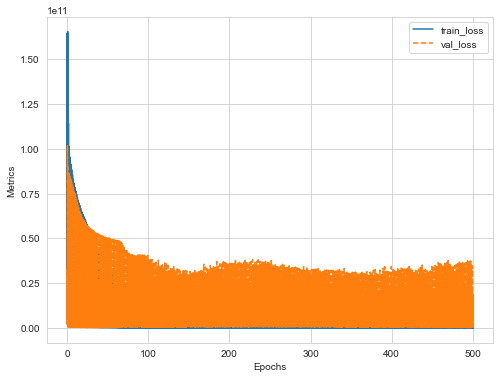



-------------This is fold 1----------------
EPOCH: 500.000	val_loss: 3344029696.000	(3499.26s - 0.00s remaining)))))))

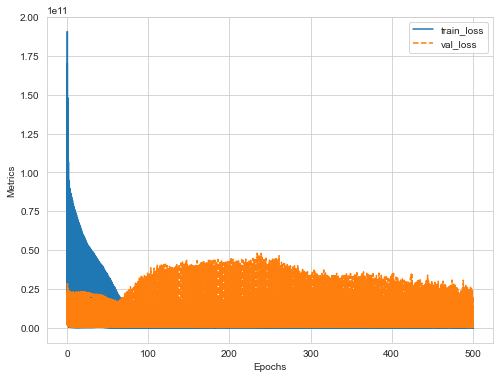



-------------This is fold 2----------------
EPOCH: 500.000	val_loss: 2517861888.000	(3624.77s - 0.00s remaining)))))))

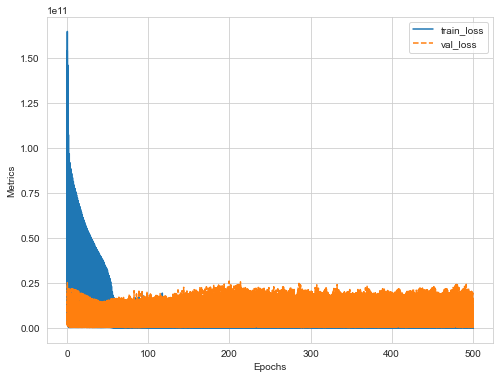



-------------This is fold 3----------------
EPOCH: 23.172	train_loss: 2130016512.000	(167.00s - 3436.44s remaining))

KeyboardInterrupt: 

In [11]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
torch.manual_seed(13)
in_features = len(x_train.iloc[0])
epochs = 500

for fold, (train_id, val_id) in enumerate(kfold.split(x_train.index)):
    train_feature, train_label = x_train.iloc[train_id], y_train.iloc[train_id]
    val_feature, val_label = x_train.iloc[val_id], y_train.iloc[val_id]
    print("\n\n-------------This is fold {}----------------".format(fold))

    train_data = PriceDataset(train_feature, train_label)
    val_data = PriceDataset(val_feature, val_label)
    train_loader = DataLoader(train_data, batch_size=16, shuffle=False, drop_last=True)
    val_loader = DataLoader(val_data, batch_size=16, shuffle=False, drop_last=True)

    model = PredictPrice(in_features).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_validate = TrainValidate(model, nn.MSELoss(), optimizer)
    train_validate.set_loader(train_loader, val_loader)
    train_validate.train(epochs)

    train_validate.save_model("models/sale_full_epoch_1000_fold_{}.pth".format(fold))